
# Comparison of Manifold Learning methods


An illustration of dimensionality reduction with various manifold learning methods.


Note that the purpose of the MDS is to find a low-dimensional
representation of the data (here 2D) in which the distances respect well
the distances in the original high-dimensional space, unlike other
manifold-learning algorithms, it does not seeks an isotropic
representation of the data in the low-dimensional space.



### Package dependencies

In [3]:
!pip install trimap
!pip install networkx
!pip install tensorflow
!conda install -c r rpy2 --yes
!conda install annoy --yes
!conda install -c conda-forge umap-learn --yes
!conda install -c conda-forge keras --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - annoy

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/linux-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/linux-64
  - https://repo.anaconda.com/pkgs/pro/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


Solving environment: done


==> WARNING: A ne

### Load elpigraph packages

In [1]:
!git clone https://github.com/j-bac/ElpiGraph.Tensorflow2_eager

Cloning into 'ElpiGraph.Tensorflow2_eager'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 134 (delta 77), reused 114 (delta 61), pack-reused 0
Receiving objects: 100% (134/134), 468.25 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [1]:
import sys
#to use elpigraph python version
sys.path.append('ElpiGraph.Tensorflow2_eager/')
sys.path.append('ElpiGraph.Tensorflow2_eager/elpigraph/core_algorithm/')

#to use elpigraph R version
%load_ext rpy2.ipython
#%R install.packages("devtools")
#%R devtools::install_github("Albluca/distutils") 
#%R devtools::install_github("Albluca/ElPiGraph.R")

In [2]:
%%R
library("ElPiGraph.R")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import NullFormatter

import networkx as nx
from elpigraph import *
from lizard_brain import lizard_brain
from PartitionData import PartitionData
from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import trimap
from umap import UMAP
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def knnsearch(A, B, n):
    indices = np.empty((B.shape[0], n),dtype=int)
    distances = np.empty((B.shape[0],B.shape[1], n))

    for i,b in enumerate(B):
        dif = np.sum(np.abs(A - b),axis=1)
#         min_ind = np.argpartition(dif,n)[:n]                        
#         ind = min_ind[np.argsort(dif[min_ind])] 
        ind = np.argsort(dif)[:n]
        indices[i, :] = ind
        distances[i, :] = dif[ind]

    return indices, distances

/home/utilisateur/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/utilisateur/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/utilisateur/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/utilisateur/.conda/envs/tf/lib/python3.7/site-

### Comparison

In [8]:
#Generate or load data
X, color, v, u, s = lizard_brain(number_of_branches = 10,
                                 dimension = 10, 
                                 epsilon = 0.005, 
                                 add_noise = 0.05, 
                                 min_branch_points = 50, 
                                 k_forknngraph = 8, 
                                 make_knn_graph = False,
                                 show_fig = False
                                )

#X = np.loadtxt('examples/ext10_10_2.txt') 
#color = np.loadtxt('examples/ext10_10_2.irx').astype('int')

#Set figure parameters
n_points = X.shape[0]
n_neighbors = 20
n_components = 2
n_subplots_x, n_subplots_y = 4, 3
cmap = plt.cm.Paired
title_fontsize = 30
points_size = 10
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

#Run methods
i = 1
pca = PCA(n_components=n_components)
t0 = time()
Y = pca.fit_transform(X)
t1 = time()
print("PCA: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("PCA",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

methods = ['standard','ltsa', 'modified']
labels = ['LLE', 'LTSA', 'Modified LLE']

for j, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[j], t1 - t0))
    i+=1
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
    plt.title("%s" % (labels[j]),fontdict = {'fontsize' : title_fontsize})
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

i += 1
t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("Isomap",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


i += 1
t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("MDS",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

i += 1
t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("SpectralEmbedding",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### t-SNE ###
i += 1
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("t-SNE",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### UMAP ###
i += 1
t0 = time()
um = UMAP(n_neighbors=n_neighbors,
          n_components=n_components)
Y = um.fit_transform(X)
t1 = time()
print("UMAP: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("UMAP",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### ElPiGraph ###
n_nodes = 120
t0 = time()
#Python version
# NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
# NodeP, Edges = NodeP.squeeze(), Edges.squeeze()

#R version
%R -i X -i n_nodes
#%R library(ElPiGraph.R)
%R TreeEPG <- computeElasticPrincipalTree(X = X, NumNodes = n_nodes,n.cores = 1,TrimmingRadius=Inf,drawAccuracyComplexity = FALSE, drawEnergy = FALSE,verbose = FALSE,drawPCAView = FALSE)
%R NodeP <- TreeEPG[[1]]$NodePositions ; Edges <- TreeEPG[[1]]$Edges$Edges ; -o NodeP -o Edges
NodeP = np.array(NodeP)
Edges = np.array(Edges).T-1

t1 = time()
print("ElPiGraph: %.2g sec" % (t1 - t0))

#ASSOCIATE EACH NODE WITH KNN DATAPOINTS
Edges2 = Edges
partition, dists = knnsearch(X,NodeP,20)
pie_col_nodes = []
main_col_nodes = []
for j0,j in enumerate(partition):
    pie_col_nodes.append(color[partition[j0]])
    main_col_nodes.append(np.argmax(np.bincount(color[partition[j0]])))
    
#CREATE GRAPH
i += 1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)

g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.kamada_kawai_layout(g,scale=2)
# ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
# nc = nx.draw_networkx_nodes(g, pos,
#                             nodelist=list(np.unique(Edges2)),
#                             node_color=main_col_nodes, 
#                             node_size=70,
#                             cmap=cmap)

# Scatter nodes
idx=np.array([pos[j] for j in range(len(pos))])
plt.scatter(idx[:,0],idx[:,1],s=10,c='black')

#Scatter datapoints in disk around nodes
for j in range(len(partition)):
    # random distance from center
    r = np.sqrt(np.random.uniform(0, .0025,size=partition.shape[1]))
    # random angle
    alpha = 2 * np.pi * np.random.random(size=partition.shape[1])
    # calculating coordinates
    x = r * np.cos(alpha) + idx[j,0]
    y = r * np.sin(alpha) + idx[j,1]

    #plt.scatter(x,y,c=[main_col_nodes[i]]*len(x),s=5,cmap=discrete_cmap(12,cmap))
    plt.scatter(x,y,c=pie_col_nodes[j],cmap=cmap,s=points_size)
    plt.clim(1,12)

#Plot edges
for j in range(Edges.shape[1]):
    x_coo = np.concatenate((idx[Edges2[0,j],[0]],idx[Edges2[1,j],[0]]))
    y_coo = np.concatenate((idx[Edges2[0,j],[1]],idx[Edges2[1,j],[1]]))
    plt.plot(x_coo,y_coo,c='black',linewidth=1.5,alpha=.8)

plt.title("ElPiGraph",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')



### Autoencoder ###
layer_sizes = [64,32,16,8]
#encoder
inputs = Input(shape=(X.shape[1],), name='encoder_input')
x = inputs
for size in layer_sizes:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
latent = Dense(n_components,kernel_initializer='he_uniform', name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

#decoder
latent_inputs = Input(shape=(n_components,), name='decoder_input')
x = latent_inputs
for size in layer_sizes[::-1]:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
outputs = Dense(X.shape[1] ,activation='sigmoid',kernel_initializer='he_uniform',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

#autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

#model summary
# encoder.summary()
# decoder.summary()
# autoencoder.summary()
X_01 = (X-X.min())/(X.max()-X.min())
autoencoder.compile(loss='mse', optimizer='adam')
t0 = time()
autoencoder.fit(x=X_01,y=X_01,epochs=200,verbose=0)
Y = encoder.predict(X)
t1 = time()
print("Autoencoder: %.2g sec" % (t1 - t0))

i += 1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("Autoencoder",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')



### VAE ###
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(n_components,))
#     return z_mean + K.exp(z_log_var) * epsilon

# layer_sizes = [64,32,16,8]
# #encoder
# inputs = Input(shape=(X.shape[1],), name='encoder_input')
# x = inputs
# for size in layer_sizes:
#     x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
    
# z_mean = Dense(n_components,kernel_initializer='he_uniform', name='latent_mean')(x)
# z_log_var = Dense(n_components,kernel_initializer='he_uniform', name='latent_sigma')(x)

# z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
# encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# #decoder
# latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
# x = latent_inputs
# for size in layer_sizes[::-1]:
#     x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
# outputs = Dense(X.shape[1] ,activation='sigmoid',kernel_initializer='he_uniform',name='decoder_output')(x)
# decoder = Model(latent_inputs, outputs, name='decoder')

# #autoencoder
# vae = Model(inputs, decoder(encoder(inputs)[2]), name='vae')


# def vae_loss(x, x_decoded_mean):
#     xent_loss = K.mean(K.square((x- x_decoded_mean)))
#     kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return xent_loss + kl_loss
# vae.compile(optimizer='adam', loss=vae_loss)

# X_01 = (X-X.min())/(X.max()-X.min())
# t0 = time()
# vae.fit(x=X_01,y=X_01,epochs=200,verbose=0)
# Y = encoder.predict(X)[0]
# t1 = time()
# print("VAE: %.2g sec" % (t1 - t0))
# i += 1
# ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
# plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
# plt.title("VAE",fontdict = {'fontsize' : title_fontsize})
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# plt.axis('tight')



### TRIMAP ###
t0 = time()
Y = trimap.TRIMAP(verbose=False).fit_transform(X)
t1 = time()
print("TRIMAP: %.2g sec" % (t1 - t0))
i += 1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap,s=points_size)
plt.title("TRIMAP",fontdict = {'fontsize' : title_fontsize})
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.tight_layout()
plt.show()

### Testing ElPiGraph

#### R version

In [12]:
%%R
library("ElPiGraph.R")
#library(igraph)

nnodesR <- 100
data <- read.table('examples/ext10_10_2.txt',header=FALSE,sep="\t")
data <- as.matrix(data)
TreeEPG <- computeElasticPrincipalTree(X = data, NumNodes = nnodesR,
                                       n.cores = 1,
                                       TrimmingRadius=Inf,
                                       drawAccuracyComplexity = FALSE, 
                                       drawEnergy = FALSE,
                                       verbose = FALSE,
                                       drawPCAView = FALSE)

NodePR <- TreeEPG[[1]]$NodePositions
EdgesR <- TreeEPG[[1]]$Edges$Edges

[1] "Generating the initial configuration"
[1] "Creating a chain in the 1st PC with 2 nodes"
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Performing PCA on the data"
[1] "Using standard PCA"
[1] "10 dimensions are being used"
[1] "100% of the original variance has been retained"
[1] "The elastic matrix is being used. Edge configuration will be ignored"
[1] "Computing EPG with 100 nodes on 1550 points and 10 dimensions"
[1] "Using a single core"
Nodes = 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD
1|0|1|2|5||100	0.01317	100	99	72	5	0	0	0.005662	0.005249	0.9856	0.9867	0.007253	0.0002554	0.02554	2.554	0
184.675 sec elapsed


In [13]:
%R -o NodePR -o EdgesR -o nnodesR
NodeP = np.array(NodePR)
Edges = np.array(EdgesR).T-1
nnodes = int(nnodesR[0])

#### Python version

In [ ]:
nnodes = 36
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()

### Graph viz

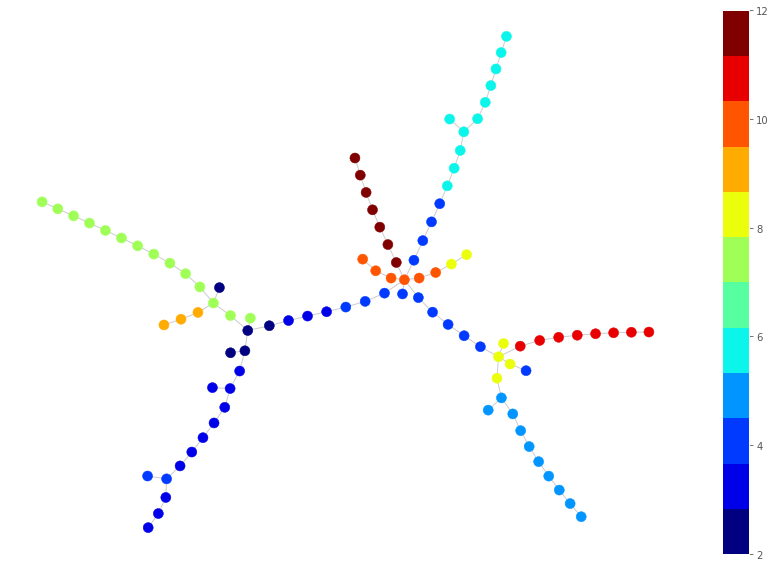

In [14]:
plt.figure(figsize=(15,10))

#optional knn tree/MST display for comparison
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# distances, indices = nbrs.kneighbors(X)
# g=nx.Graph()
# g.add_edges_from(indices)
# pos = nx.kamada_kawai_layout(g,scale=2)
# ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
# nc = nx.draw_networkx_nodes(g, pos,
#                             nodelist=list(np.unique(indices)),
#                             node_color=color, 
#                             node_size=100,
#                             cmap=plt.cm.jet)
# T=nx.minimum_spanning_tree(g)

#ASSOCIATE EACH DATAPOINT WITH ONE NODE
# partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX=(X**2).sum(axis=1).reshape((X.shape[0], 1)))
# #remove nodes with no associated datapoint
# empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
# Edges2=Edges
# ind_to_del = []
# for i in range(Edges.shape[1]):
#     if (Edges2[0,i] in empty_nodes) or (Edges2[1,i] in empty_nodes):
#         ind_to_del.append(i)
# Edges2 = np.delete(Edges,ind_to_del,axis=1)
# #associate color(s) to nodes
# pie_col_nodes = []
# main_col_nodes = []
# for i0,i in enumerate(np.unique(partition)):
#     pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
#     main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))
    
#OR ASSOCIATE EACH NODE WITH KNN DATAPOINTS
Edges2 = Edges
partition, dists = knnsearch(X,NodeP,20)
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(partition):
    pie_col_nodes.append(color[partition[i0]])
    main_col_nodes.append(np.argmax(np.bincount(color[partition[i0]])))

### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.kamada_kawai_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)), #list(np.unique(partition)) if using PartitionData
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=discrete_cmap(12,cmap))


plt.colorbar(nc)
plt.axis('off')
plt.show()

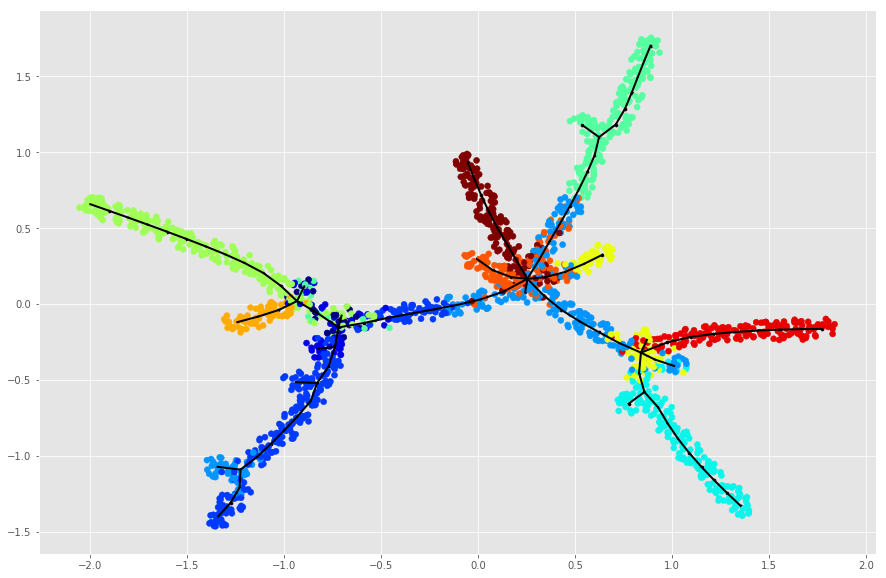

In [28]:
plt.figure(figsize=(15,10))
# Scatter nodes
idx=np.array([pos[i] for i in range(len(pos))])
plt.scatter(idx[:,0],idx[:,1],s=10,c='black')

#Plot datapoints in circle around nodes
for i in range(len(partition)):
    # radius of the circle
    r = np.sqrt(np.random.uniform(0, .005,size=partition.shape[1]))
    # random angle
    alpha = 2 * np.pi * np.random.random(size=partition.shape[1])
    # calculating coordinates
    x = r * np.cos(alpha) + idx[i,0]
    y = r * np.sin(alpha) + idx[i,1]

    #plt.scatter(x,y,c=[main_col_nodes[i]]*len(x),s=5,cmap=discrete_cmap(12,cmap))
    plt.scatter(x,y,c=pie_col_nodes[i],cmap=cmap,alpha=1)
    plt.clim(1,12)

#Plot edges
for i in range(Edges.shape[1]):
    x_coo = np.concatenate((idx[Edges2[0,i],[0]],idx[Edges2[1,i],[0]]))
    y_coo = np.concatenate((idx[Edges2[0,i],[1]],idx[Edges2[1,i],[1]]))
    plt.plot(x_coo,y_coo,c='black',linewidth=2)